In [24]:
import warnings
import itertools
import numpy as np 
import pandas as pd
import seaborn as sns
import lightgbm as lgb
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, log_loss

warnings.simplefilter(action='ignore')
sns.set_style('whitegrid')

In [25]:
import pandas as pd
data_train = pd.read_csv("train.csv")

In [26]:
data_test = pd.read_csv("test.csv")

In [27]:
data_df = [data_train, data_test]

In [28]:
data_train.head()

,crew,experiment,time,seat,eeg_fp1,eeg_f7,eeg_f8,eeg_t4,eeg_t6,eeg_t5,...,eeg_c4,eeg_p4,eeg_poz,eeg_c3,eeg_cz,eeg_o2,ecg,r,gsr,event
0,1,CA,0.011719,1,-5.28545,26.775801,-9.527310,-12.793200,16.717800,33.737499,...,37.368999,17.437599,19.201900,20.5968,-3.95115,14.507600,-4520.0,817.705994,388.829987,A
1,1,CA,0.015625,1,-2.42842,28.430901,-9.323510,-3.757230,15.969300,30.443600,...,31.170799,19.399700,19.689501,21.3547,1.33212,17.750200,-4520.0,817.705994,388.829987,A
2,1,CA,0.019531,1,10.67150,30.420200,15.350700,24.724001,16.143101,32.142799,...,-12.012600,19.396299,23.171700,22.4076,1.53786,22.247000,-4520.0,817.705994,388.829987,A
3,1,CA,0.023438,1,11.45250,25.609800,2.433080,12.412500,20.533300,31.494101,...,18.574100,23.156401,22.641199,19.3367,2.54492,18.998600,-4520.0,817.705994,388.829987,A
4,1,CA,0.027344,1,7.28321,25.942600,0.113564,5.748000,19.833599,28.753599,...,6.555440,22.754700,22.670300,20.2932,1.69962,22.812799,-4520.0,817.705994,388.829987,A


In [29]:
data_train.shape

(4867421, 28)

## General analysis

In [30]:
data_train.dtypes

crew            int64
experiment     object
time          float64
seat            int64
eeg_fp1       float64
eeg_f7        float64
eeg_f8        float64
eeg_t4        float64
eeg_t6        float64
eeg_t5        float64
eeg_t3        float64
eeg_fp2       float64
eeg_o1        float64
eeg_p3        float64
eeg_pz        float64
eeg_f3        float64
eeg_fz        float64
eeg_f4        float64
eeg_c4        float64
eeg_p4        float64
eeg_poz       float64
eeg_c3        float64
eeg_cz        float64
eeg_o2        float64
ecg           float64
r             float64
gsr           float64
event          object
dtype: object

In [31]:
for df in data_df:
    df.crew = df.crew.astype('category')
    df.experiment = df.experiment.astype('category')
    df.seat = df.seat.astype('category')
    
data_train.event = data_train.event.astype('category')

In [32]:
# missing values
data_train.isnull().sum().sum(), data_test.isnull().sum().sum()

(0, 0)

## Analyze by column

### Categorical columns

In [33]:
# There is no significant relationship between event and crew columns. Crew column is a candidate for deletion.
data_train[['event', 'crew']].groupby(['event', 'crew'], as_index=False).size()

event  crew
A      1       235891
       2       326570
       3       327147
       4       328532
       5       326326
       6       327851
       7       327917
       8       323875
       13      324700
B      1         7689
       2        15371
       3        15337
       4        15364
       5        15368
       6        15348
       7        15388
       8        15356
       13       15376
C      1       180853
       2       183888
       3       184062
       4       184088
       5       183934
       6       183888
       7       183946
       8       184055
       13      183972
D      1        23219
       2        27039
       3        26249
       4        24897
       5        27187
       6        25871
       7        25518
       8        26673
       13       28676
dtype: int64

In [34]:
data_train.experiment.unique().categories, data_test.experiment.unique().categories

# Experiment column is just a description column and it does not hold significant information. As it could not be used as a predictor it will be deleted.

(Index(['CA', 'DA', 'SS'], dtype='object'), Index(['LOFT'], dtype='object'))

In [35]:
data_train[['event', 'seat']].groupby(['event', 'seat'], as_index=False).size()

# There is no significant relationship between event and seat columns. Seat column is a candidate for deletion.

event  seat
A      0       1424524
       1       1424285
B      0         65293
       1         65304
C      0        826401
       1        826285
D      0        117721
       1        117608
dtype: int64

In [36]:
#Dropping categorical columns
for df in data_df:
    df.drop(columns=['crew'], inplace = True)
    df.drop(columns=['experiment'], inplace = True)
    df.drop(columns=['seat'], inplace = True)

### Numerical columns

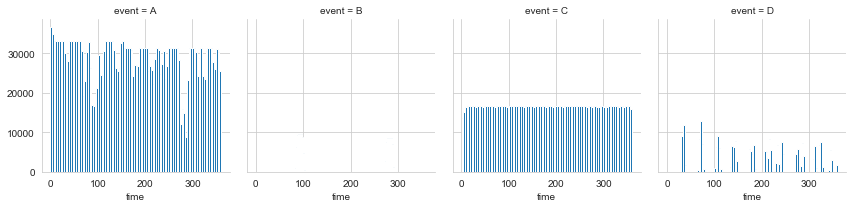

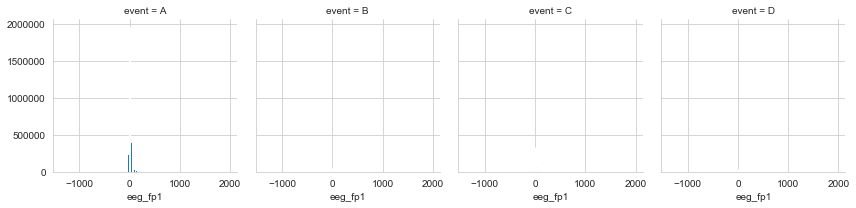

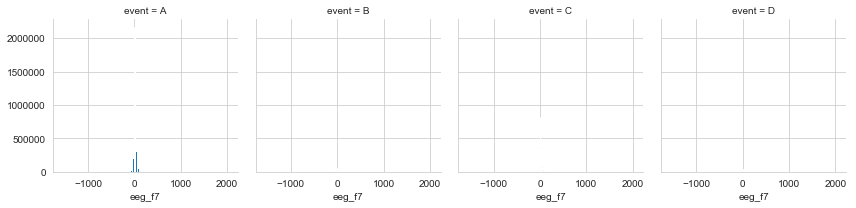

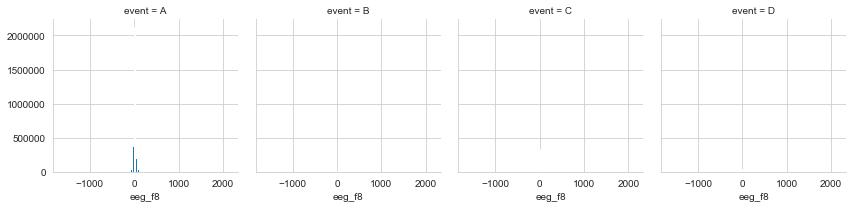

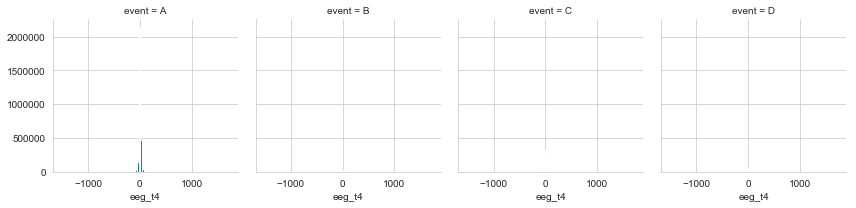

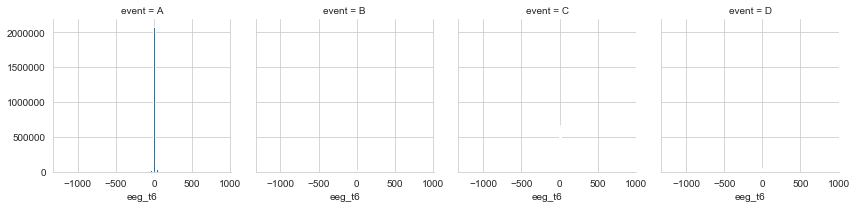

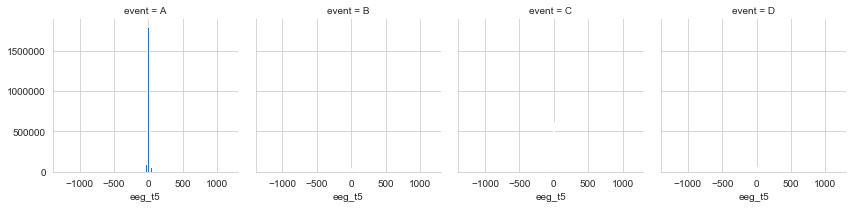

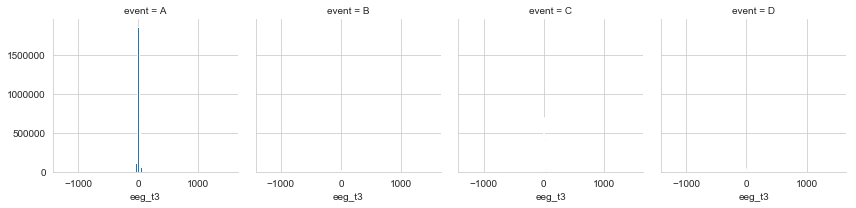

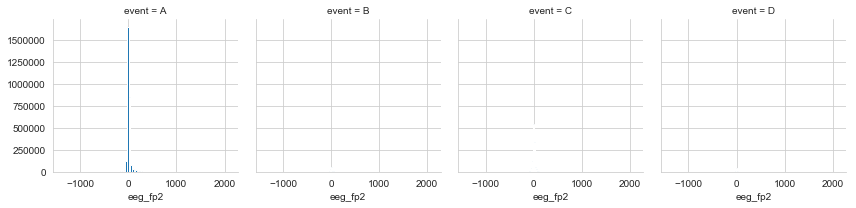

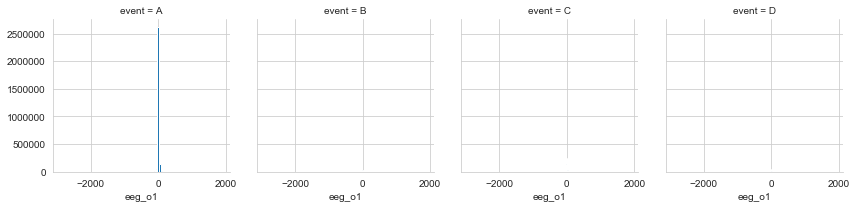

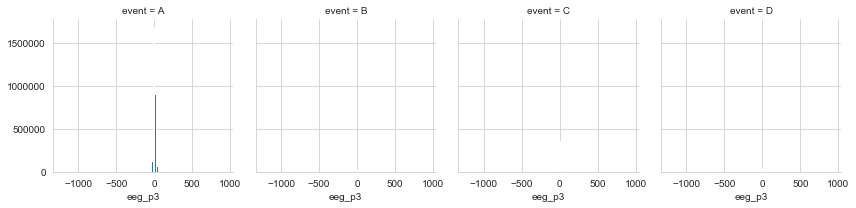

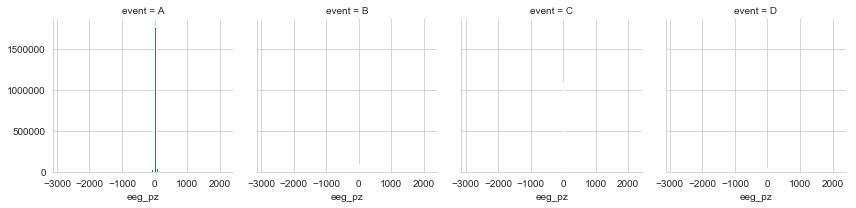

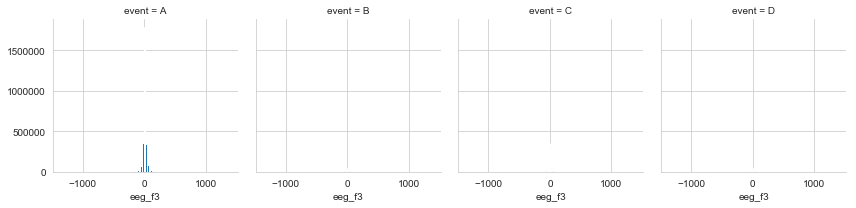

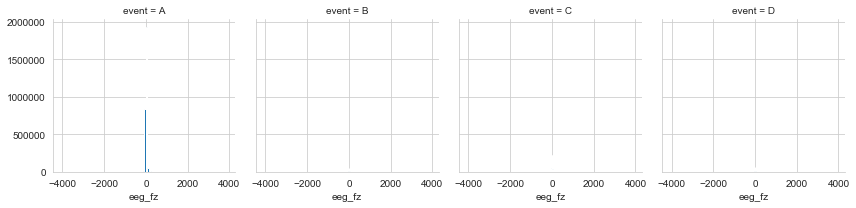

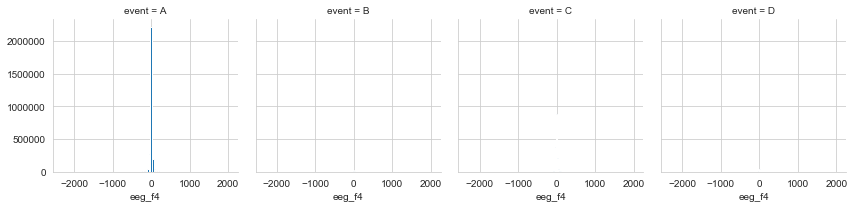

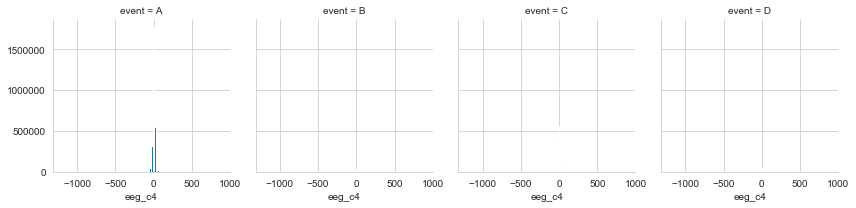

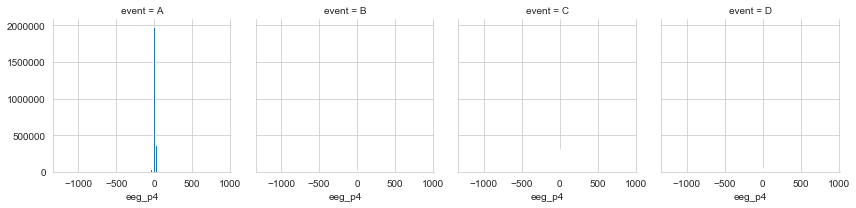

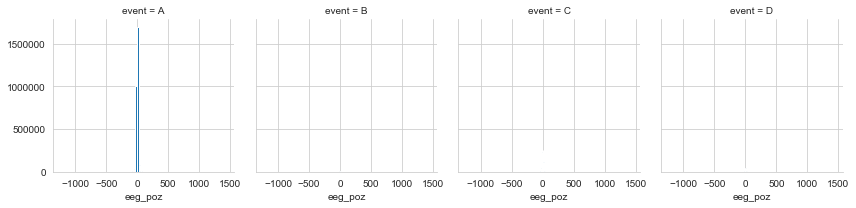

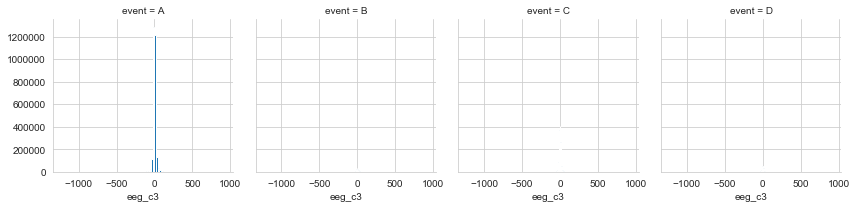

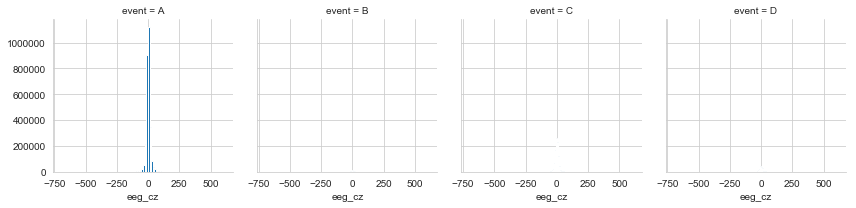

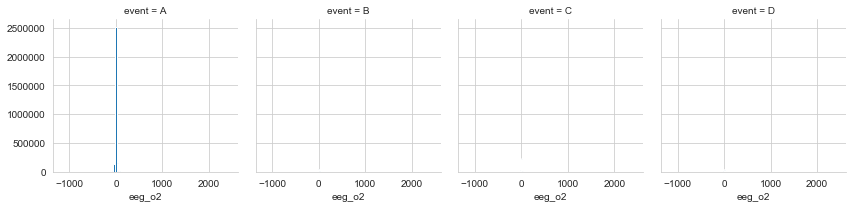

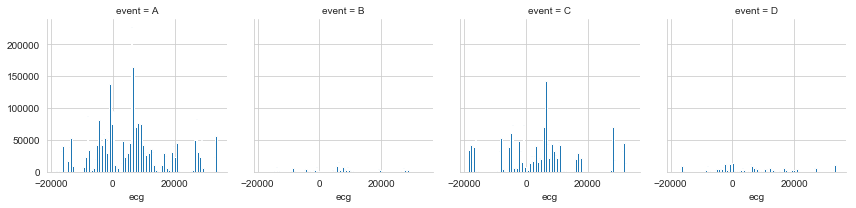

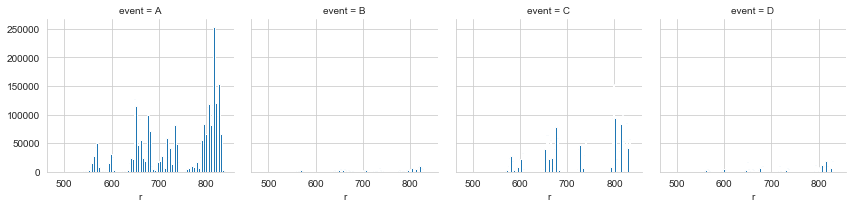

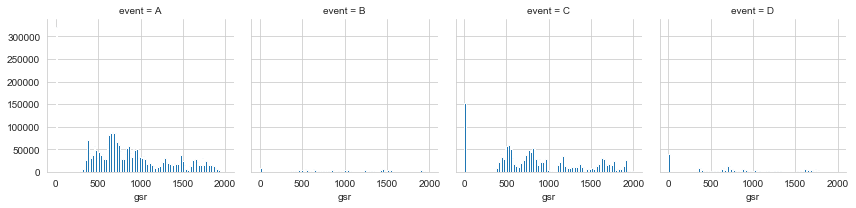

In [39]:
for predictor in data_test.columns[1:]:
    g = sns.FacetGrid(data_train, col='event')
    g.map(plt.hist, predictor, bins=100)

In [40]:
# For such columns as time, ecg, r and gsr it is hard to see some pattern. And it would be hard to capture it if it exists. Therefore, we will delete these columns.

#Dropping numerical columns
for df in data_df:
    df.drop(columns=['time'], inplace = True)
    df.drop(columns=['ecg'], inplace = True)
    df.drop(columns=['r'], inplace = True)
    df.drop(columns=['gsr'], inplace = True)

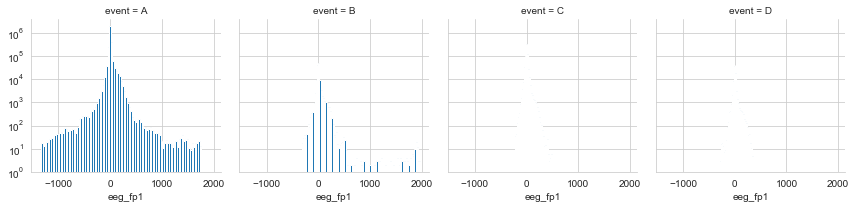

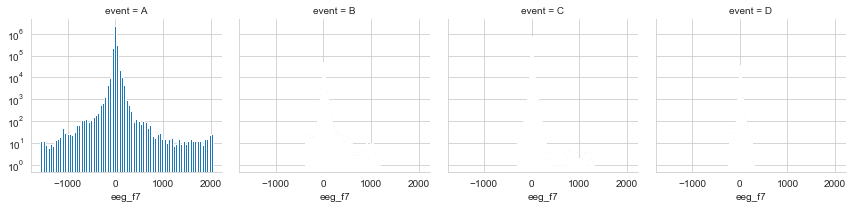

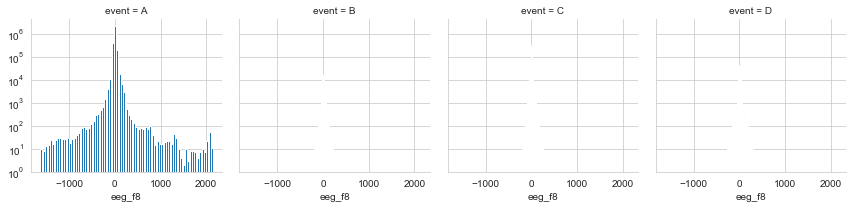

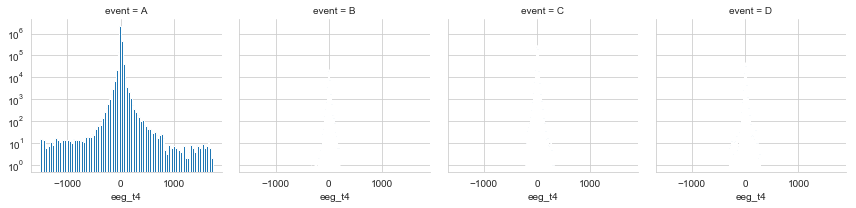

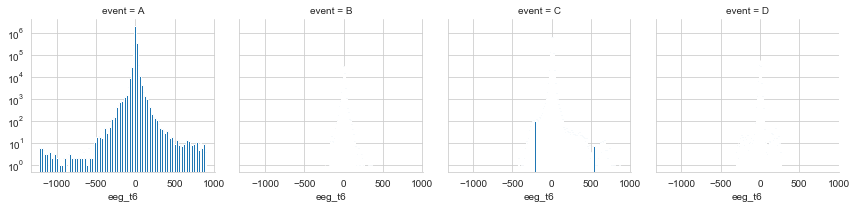

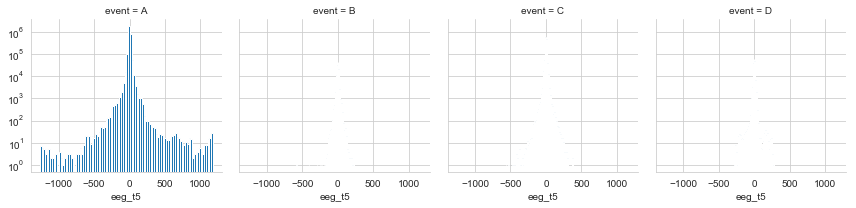

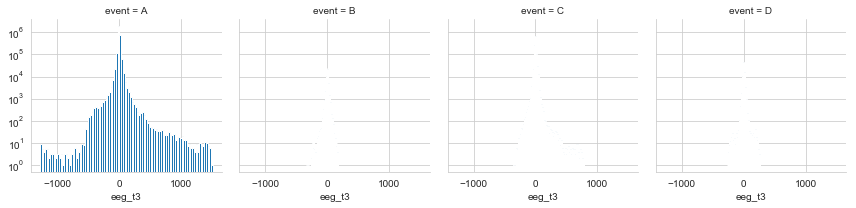

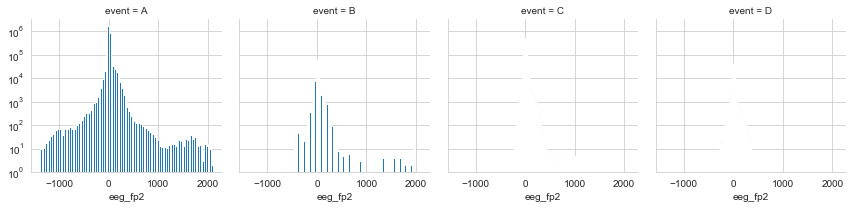

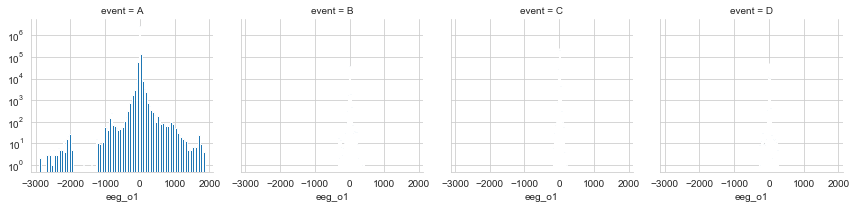

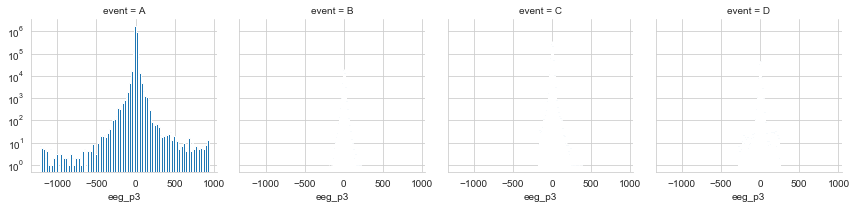

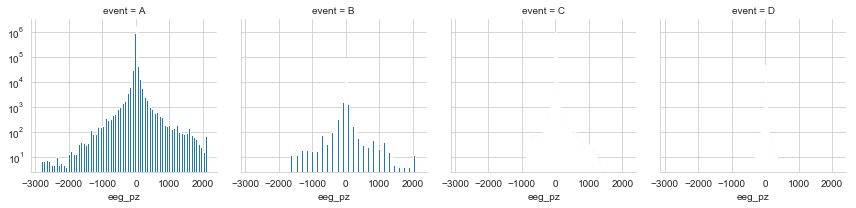

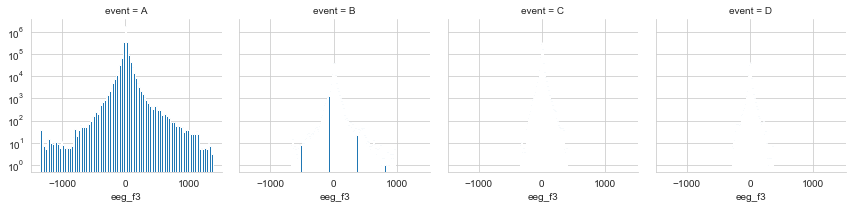

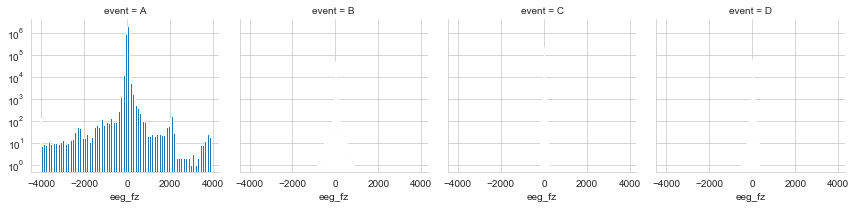

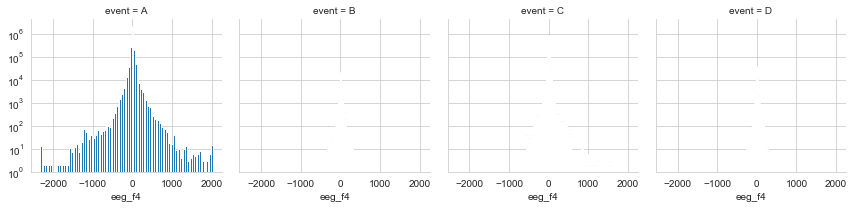

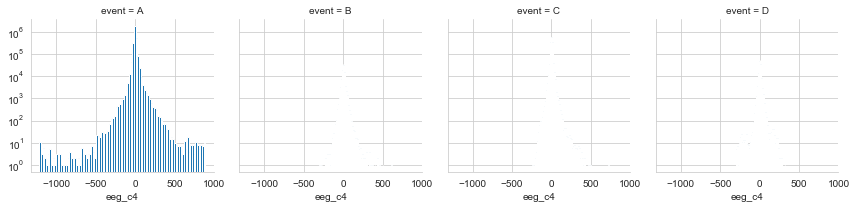

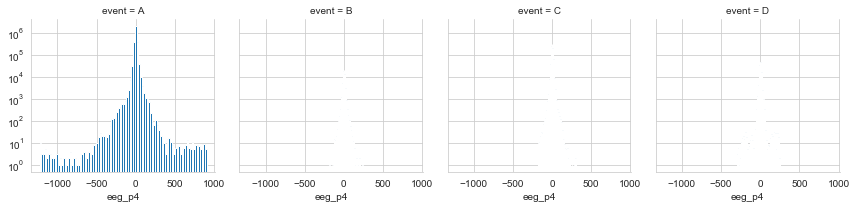

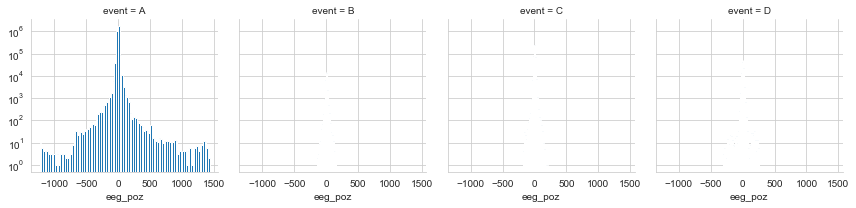

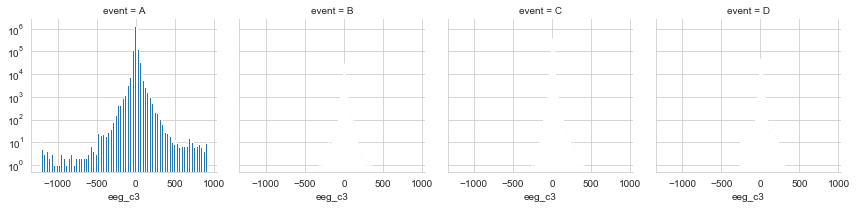

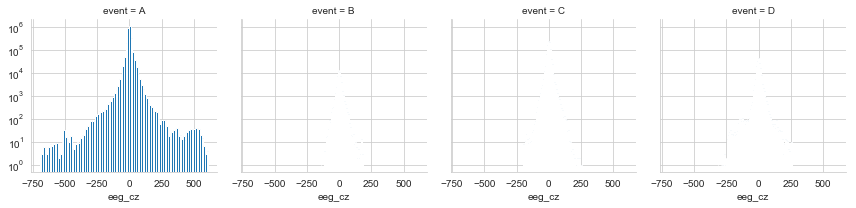

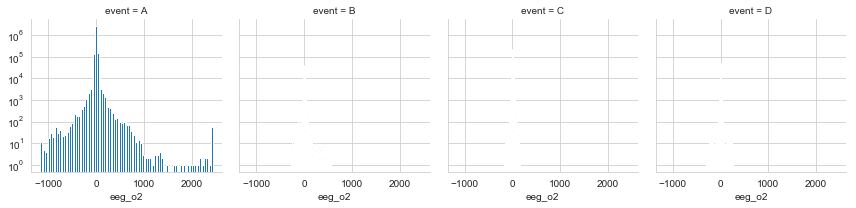

In [43]:
for predictor in data_test.columns[1:]:
    g = sns.FacetGrid(data_train, col='event')
    g.set(yscale="log")
    g.map(plt.hist, predictor, bins=100)

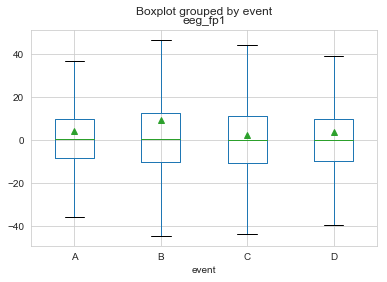

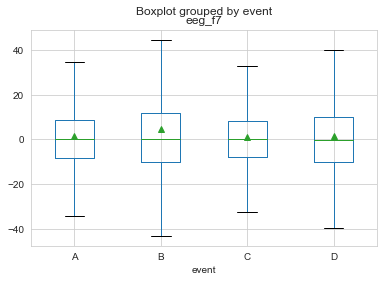

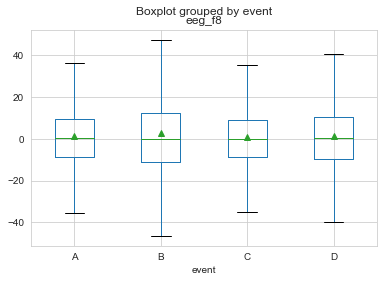

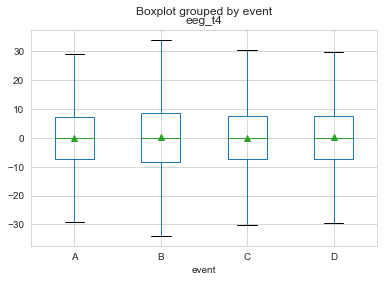

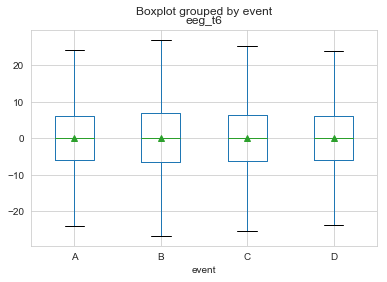

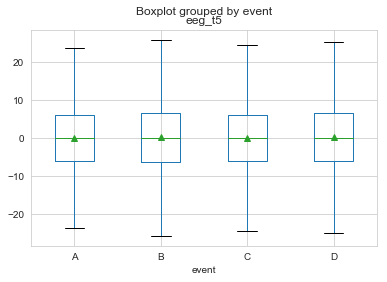

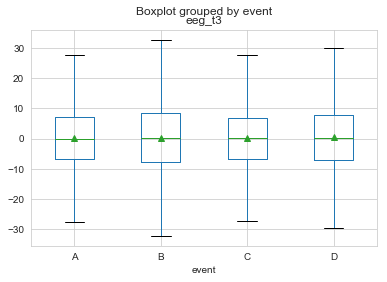

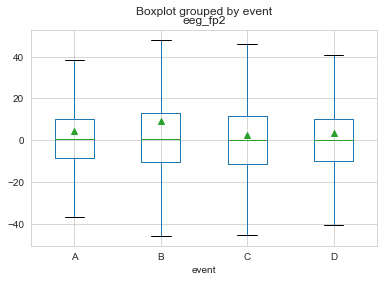

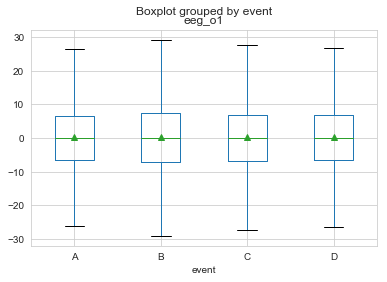

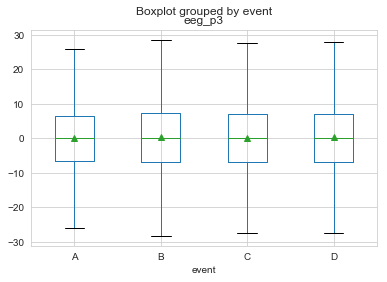

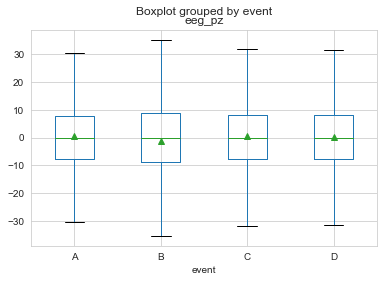

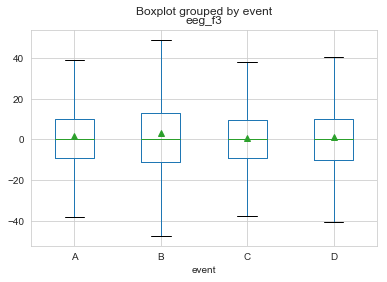

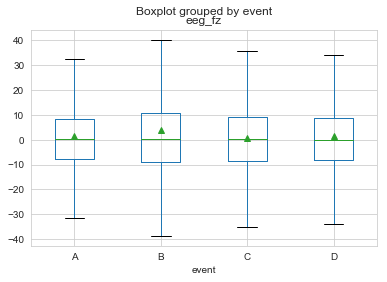

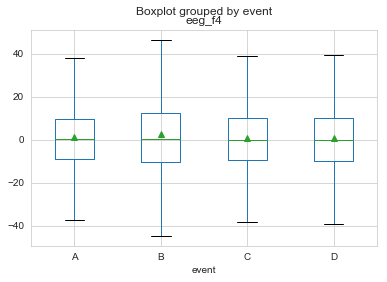

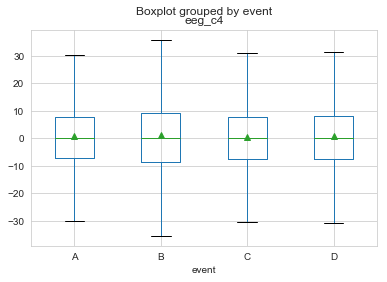

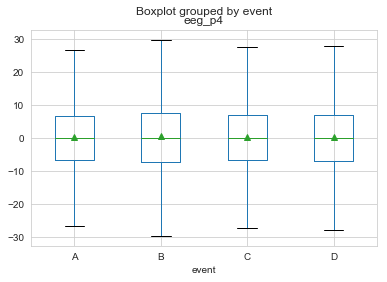

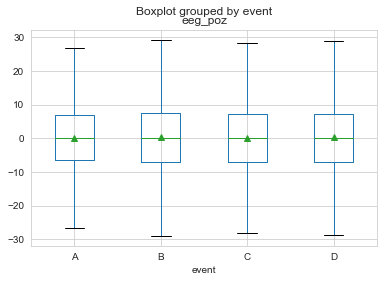

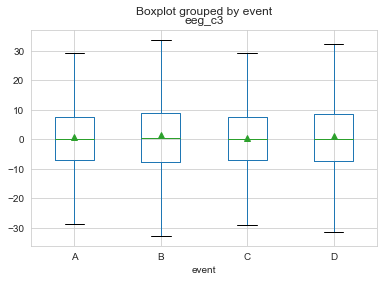

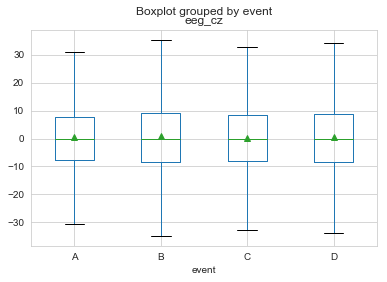

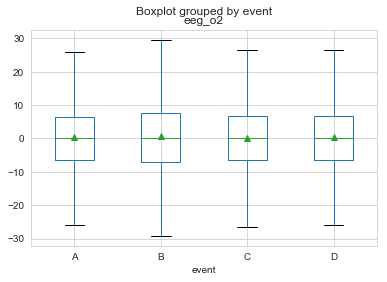

In [44]:
for predictor in data_test.columns[1:]:
    data_train.boxplot(column=predictor, by='event', showmeans=True, showfliers=False)